<a href="https://colab.research.google.com/github/Sarvaswa-Mohata/Fake-News-Detection/blob/main/Fake_news_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fakenewsnet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F72366%2F159129%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240615%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240615T141247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D65a2fa7c9b77bd5be7a930befb0bccb8acdbd81325af18f0851d5b906718e2ac5204412511cb40651ef42cf8a7d38494b6220db809ed1ef63c68b835c7fca61550814203ea67c9d9ec819ddb541caa2f29ec81ce0aa8c4a0f38ce66a200bf3471a48f894182ecbf0cbf24744b0b3797dd47357d2dae8aff36fa56a6fd5a97d354e04938b72b6fc49cc62696fa698a3daa610a3b47d57f88c175738f6f591be344ddd528d1bf53d1323448cda8042bacae421fca49af7d8888dfaddb4ae86d99660a81bb41466836af44788ef183533310bae2debe166b1692cf7a5cbb8b3b8a28233d7079dec8ed4e7b241c08c38ce22219575e9f306c3d85d07488c6ef0bd14'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 17409594 bytes downloaded
Downloaded and uncompressed: fakenewsnet
Data source import complete.


In [88]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakenewsnet/BuzzFeedUser.txt
/kaggle/input/fakenewsnet/PolitiFactNewsUser.txt
/kaggle/input/fakenewsnet/BuzzFeedNewsUser.txt
/kaggle/input/fakenewsnet/PolitiFactUserFeature.mat
/kaggle/input/fakenewsnet/BuzzFeedUserFeature.mat
/kaggle/input/fakenewsnet/PolitiFactUserUser.txt
/kaggle/input/fakenewsnet/BuzzFeedNews.txt
/kaggle/input/fakenewsnet/BuzzFeedUserUser.txt
/kaggle/input/fakenewsnet/PolitiFactNews.txt
/kaggle/input/fakenewsnet/BuzzFeed_fake_news_content.csv
/kaggle/input/fakenewsnet/BuzzFeed_real_news_content.csv
/kaggle/input/fakenewsnet/PolitiFact_real_news_content.csv
/kaggle/input/fakenewsnet/PolitiFactUser.txt
/kaggle/input/fakenewsnet/PolitiFact_fake_news_content.csv


In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [90]:
df_fake = pd.read_csv('/kaggle/input/fakenewsnet/BuzzFeed_fake_news_content.csv')
df_fake2 = pd.read_csv('/kaggle/input/fakenewsnet/PolitiFact_fake_news_content.csv')
df_fake = pd.concat([df_fake,df_fake2],axis=0)
df_fake['category']=0
df_real = pd.read_csv('/kaggle/input/fakenewsnet/BuzzFeed_real_news_content.csv')
df_real2 = pd.read_csv('/kaggle/input/fakenewsnet/PolitiFact_real_news_content.csv')
df_real = pd.concat([df_real,df_real2],axis=0)
df_real['category']=1

In [91]:
df_fake.shape

(211, 13)

In [92]:
df_real.shape

(211, 13)

In [93]:
df = pd.concat([df_real,df_fake], axis=0)

In [94]:
df.head(5)

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,category
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",1
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",1
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",1
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b...",1
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict...",1


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422 entries, 0 to 119
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              422 non-null    object
 1   title           422 non-null    object
 2   text            422 non-null    object
 3   url             410 non-null    object
 4   top_img         408 non-null    object
 5   authors         355 non-null    object
 6   source          410 non-null    object
 7   publish_date    295 non-null    object
 8   movies          39 non-null     object
 9   images          408 non-null    object
 10  canonical_link  400 non-null    object
 11  meta_data       422 non-null    object
 12  category        422 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 46.2+ KB


In [96]:
df.drop(['id','top_img','url','publish_date','movies','images','canonical_link','meta_data'],axis=1, inplace=True)

In [97]:
df.head(5)

,title,text,authors,source,category
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...","View All Posts,Leonora Cravotta",http://eaglerising.com,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",Cassy Fiano,http://rightwingnews.com,1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,1


In [98]:
df.isnull().sum()

title        0
text         0
authors     67
source      12
category     0
dtype: int64

In [99]:
# Fill null values in 'authors' column with 'Unknown'
df['authors'] = df['authors'].fillna('Unknown')

# Fill null values in 'source' column with 'Unknown'
df['source'] = df['source'].fillna('Unknown')

In [100]:
df['source_name'] = df['source'].str.extract(r"(?:https?://)?(?:www\.)?([^./]+)")
df

,title,text,authors,source,category,source_name
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...","View All Posts,Leonora Cravotta",http://eaglerising.com,1,eaglerising
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,1,abcn
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",Cassy Fiano,http://rightwingnews.com,1,rightwingnews
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,1,politi
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,1,abcn
...,...,...,...,...,...,...
115,"Donald Trump, Germany’s disfavored son – POLITICO","KALLSTADT, Germany — Few places in Germany are...","Matthew Karnitschnig,Janosch Delcker",http://politi.co,0,politi
116,BREAKING: Hollywood Legend Just Died Of Terrib...,Hollywood loses yet another one of their deare...,Nancy Wells,http://newsbake.com,0,newsbake
117,Worst. President. Ever.,"As my 25th wedding anniversary approached, I t...","Jack Shafer,Robert Strauss",http://politi.co,0,politi
118,Don King drops N-word while introducing Donald...,Story highlights Trump was sitting in a chair ...,Jeremy Diamond,http://cnn.it,0,cnn


In [101]:
new = []
for x in df[df['category'] == 0]['source'].unique():
    if x in df[df['category'] == 1]['source'].unique():
        match = re.search(r"(?:https?://)?(?:www\.)?([^./]+)", x)
        if match:
            main_name = match.group(1)
            if main_name not in new:
                new.append(main_name)

print(new)

['addictinginfo', 'eaglerising', 'conservativebyte', 'Unknown', 'winningdemocrats', 'freedomdaily', 'author', 'occupydemocrats', 'rightwingnews', 'chicksontheright', 'cnn', 'newsbake', 'politi', 'abcn', 'opposingviews', 'liberalamerica']


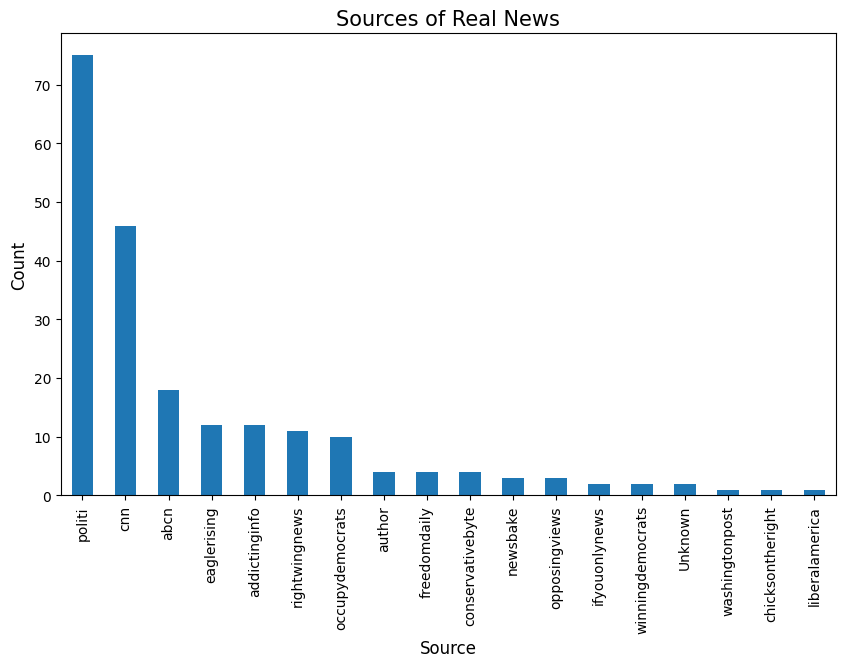

In [102]:
source_counts = df[df['category'] == 1]['source_name'].value_counts()

# Create a bar plot of the source counts
plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar')
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Sources of Real News', fontsize=15)
plt.show()

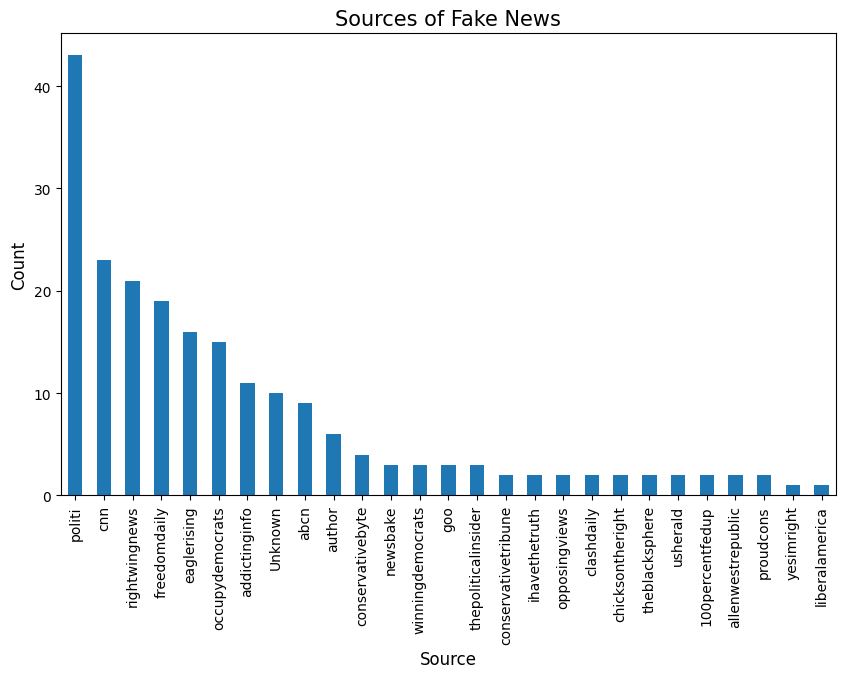

In [103]:
source_counts = df[df['category'] == 0]['source_name'].value_counts()

# Create a bar plot of the source counts
plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar')
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Sources of Fake News', fontsize=15)
plt.show()

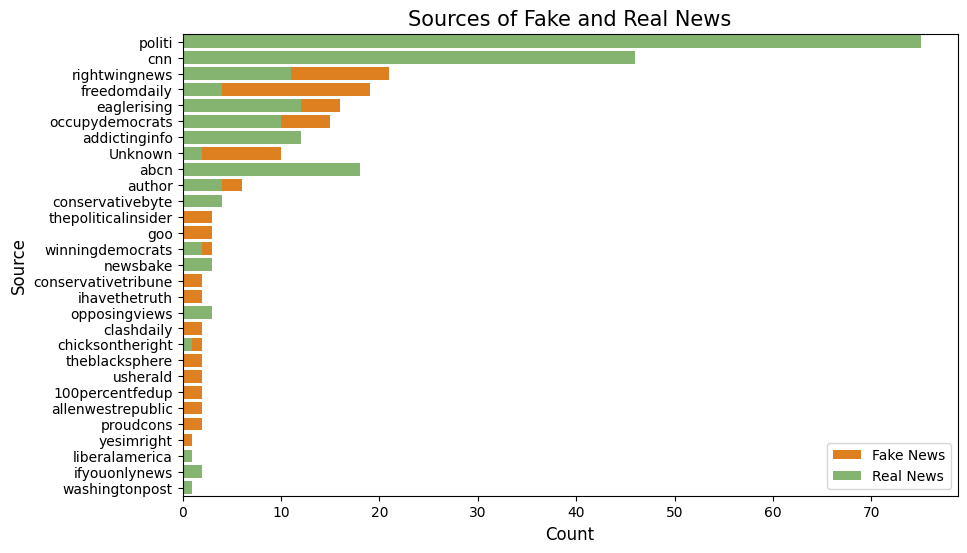

In [104]:
# Countplot for fake news
fake_order = df[df['category'] == 0]['source_name'].value_counts().sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.countplot(y='source_name', data=df[df['category'] == 0], order=fake_order, palette='autumn', label='Fake News', hue='category', legend=False)

# Countplot for real news
real_order = df[df['category'] == 1]['source_name'].value_counts().sort_values(ascending=False).index
sns.countplot(y='source_name', data=df[df['category'] == 1], order=real_order, palette='summer', label='Real News', hue='category', legend=False)

plt.xlabel('Count', fontsize=12)
plt.ylabel('Source', fontsize=12)
plt.title('Sources of Fake and Real News', fontsize=15)
plt.legend()
plt.show()

In [105]:

ps=PorterStemmer()
wst= WhitespaceTokenizer()

##### 1. Converting text to lower case
def lower_func (x):
    return x.lower()


##### 2. Removing Numbers from the text corpus
def remove_number_func (x):
    new=""
    for a in x:
        if a.isdigit()==False:
            new=new+a
    return new


##### 3. Removing punctuation
def remove_punc_func(x):
    new=''
    for a in x:
        if a not in string.punctuation:
            new=new+a
    return new

##### 4. Removing special characters
def remove_spec_char_func(x):
    new=''
    for a in x:
        if (a.isalnum()==True) or (a==' '):
            new=new+a
    return(new)

##### 5. Removing english stopwords
def remove_stopwords(x):
    new=[]
    for a in x.split():
        if a not in stopwords.words('english'):
            new.append(a)
    return " ".join(new)

##### 6. Stemming words to root words
def stem_func(x):
    wordlist = word_tokenize(x)
    psstem = [ps.stem(a) for a in wordlist]
    return ' '.join(psstem)

##### 7. Removing extra whitespaces
def remove_whitespace_func(x):
    return(wst.tokenize(x))

def compose(f, g):
    return lambda x: f(g(x))

final=compose(compose(compose(compose(compose(compose(remove_whitespace_func,stem_func),remove_stopwords),remove_spec_char_func),remove_punc_func),remove_number_func),lower_func)

In [106]:
df_fake=df[df['category']==0]

In [107]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [108]:
cv1 = CountVectorizer(analyzer=final)
cv1.fit(df_fake['title'])
bow1=cv1.transform(df_fake['title'])

In [109]:
pd.DataFrame(bow1.todense()).shape

(211, 872)

In [110]:
new1=[]
for x in range(0,872):
    new1.append(cv1.get_feature_names_out()[x])

In [111]:
matrix1=pd.DataFrame(bow1.todense(),columns=new1)

In [112]:
sm1=[]
for x in new1:
    sm1.append(matrix1[x].sum())

In [113]:
trans1=matrix1.transpose()

In [114]:
trans1['sum']=sm1

In [115]:
top1=trans1.sort_values(by='sum', ascending=False).head(40)

In [116]:
df_real=df[df['category']==1]

In [117]:
cv2 = CountVectorizer(analyzer=final)
cv2.fit(df_real['title'])
bow2=cv2.transform(df_real['title'])

In [118]:
pd.DataFrame(bow2.todense()).shape

(211, 835)

In [119]:
new2=[]
for x in range(0,835):
    new2.append(cv2.get_feature_names_out()[x])

In [120]:
matrix2=pd.DataFrame(bow2.todense(),columns=new2)

In [121]:
sm2=[]
for x in new2:
    sm2.append(matrix2[x].sum())

In [122]:
trans2=matrix2.transpose()

In [123]:
trans2['sum']=sm2

In [124]:
top2=trans2.sort_values(by='sum', ascending=False).head(40)

In [125]:
top1.drop(list(range(0,211)),axis=1,inplace=True)

In [126]:
top1['category']=[0]*40

In [127]:
top2.drop(list(range(0,211)),axis=1,inplace=True)

In [128]:
top2['category']=[1]*40

In [129]:
conc1=pd.concat([top1,top2])

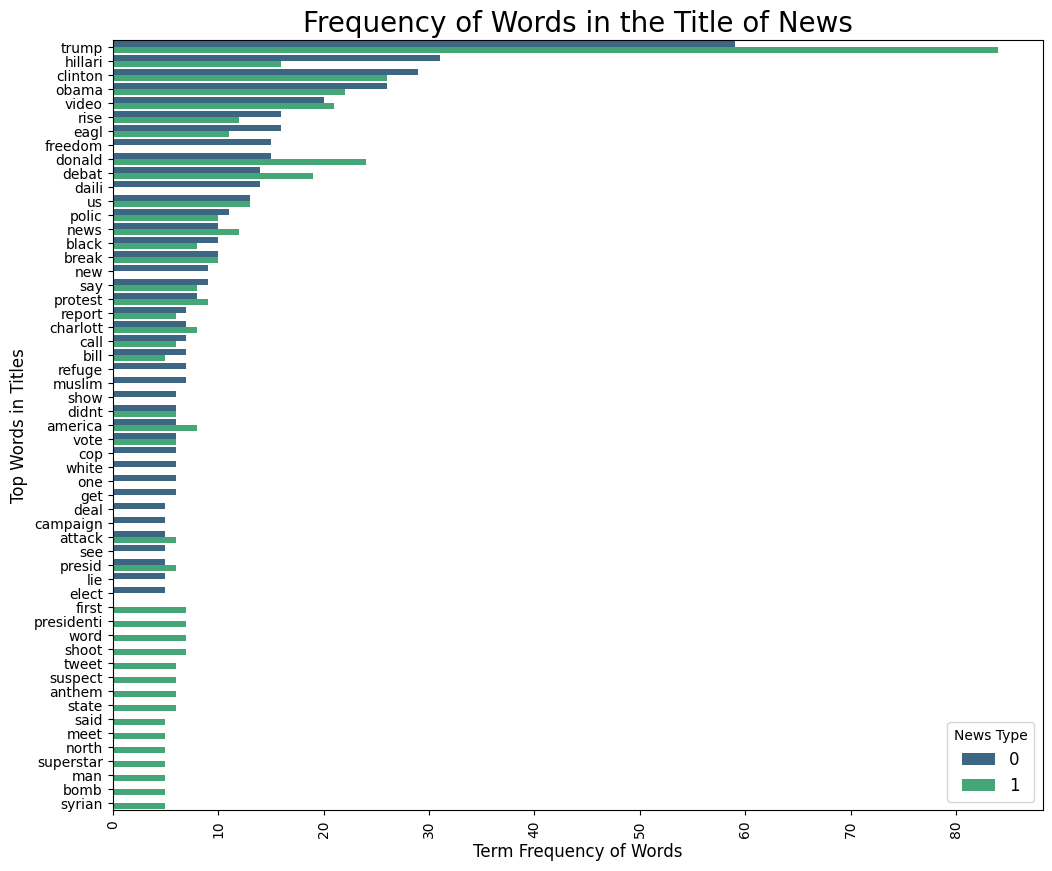

In [130]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc1.index,x='sum',data=conc1,hue='category',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Titles',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Title of News',fontsize=20)
plt.show()

In [131]:
cv3 = CountVectorizer(analyzer=final)
cv3.fit(df_fake['text'])
bow3=cv3.transform(df_fake['text'])

In [132]:
pd.DataFrame(bow3.todense()).shape

(211, 10086)

In [133]:
new3=[]
for x in range(0,10086):
    new3.append(cv3.get_feature_names_out()[x])

In [134]:
matrix3=pd.DataFrame(bow3.todense(),columns=new3)

In [135]:
sm3=[]
for x in new3:
    sm3.append(matrix3[x].sum())

In [136]:
trans3=matrix3.transpose()

In [137]:
trans3['sum']=sm3

In [138]:
top3=trans3.sort_values(by='sum', ascending=False).head(40)

In [139]:
cv4 = CountVectorizer(analyzer=final)
cv4.fit(df_real['text'])
bow4=cv4.transform(df_real['text'])

In [140]:
pd.DataFrame(bow4.todense()).shape

(211, 11100)

In [141]:
new4=[]
for x in range(0,11100):
    new4.append(cv4.get_feature_names_out()[x])

In [142]:
matrix4=pd.DataFrame(bow4.todense(),columns=new4)

In [143]:
sm4=[]
for x in new4:
    sm4.append(matrix4[x].sum())

In [144]:
trans4=matrix4.transpose()

In [145]:
trans4['sum']=sm4

In [146]:
top4=trans4.sort_values(by='sum', ascending=False).head(40)

In [147]:
top3.drop(list(range(0,211)),axis=1,inplace=True)

In [148]:
top3['category']=[0]*40

In [149]:
top4.drop(list(range(0,211)),axis=1,inplace=True)

In [150]:
top4['category']=[1]*40

In [151]:
conc2=pd.concat([top3,top4])

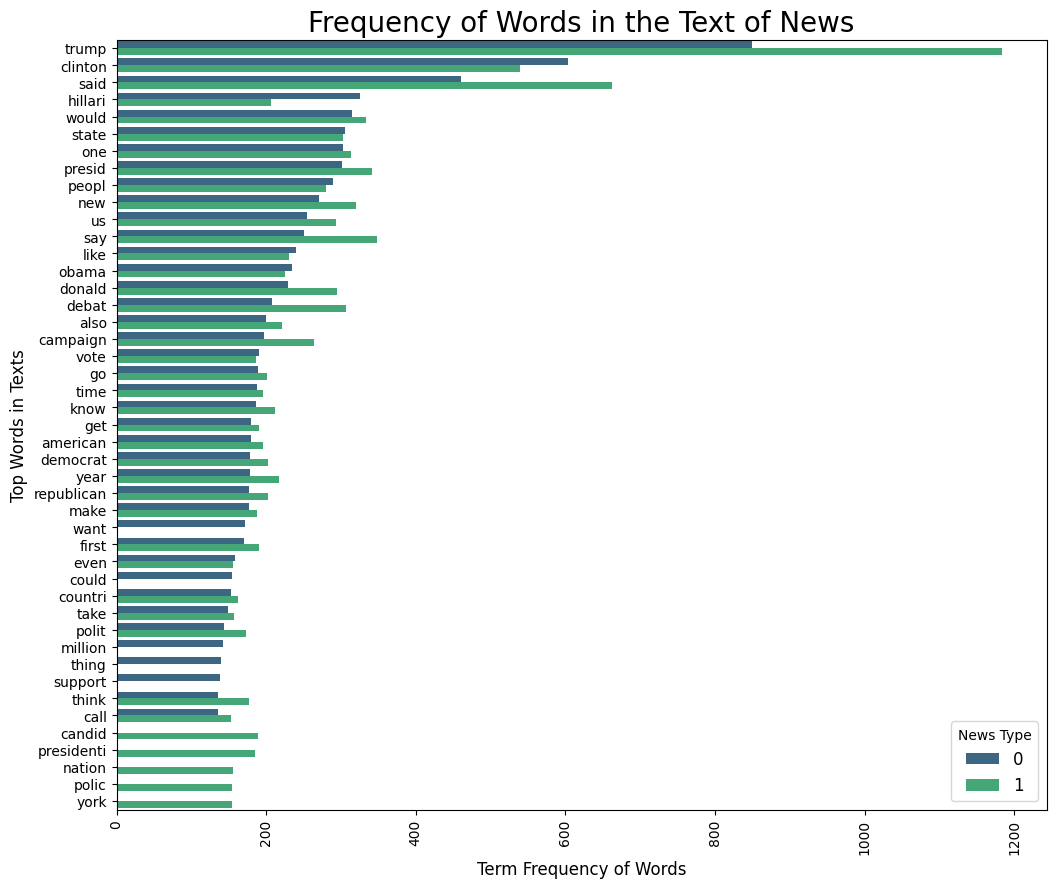

In [152]:
plt.figure(figsize=(12,10))
sns.barplot(y=conc2.index,x='sum',data=conc2,hue='category',palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Texts',fontsize=12)
plt.legend(title='News Type',fontsize=12,loc='lower right')
plt.title('Frequency of Words in the Text of News',fontsize=20)
plt.show()